# 5. Income versus all explanatory variables

In the previous notebook, we have conducted substantial analysis on the pairwise relationships among qualitative demographic variables (i.e. sex, race, occupation, marital status) and quantitative demographic variables (i.e. education, working hours per week). In this final notebook, we will discuss the extent to which all these qualitative and quantitative variables affect the annual income. The original dataset separated individuals' annual income level into two categories: below 50k (negative outcome) and above 50k (positive outcome).

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import shelve
import os
import scipy
import scipy.stats as stats
from itertools import combinations
# from IPython.display import display

plt.style.use('seaborn-dark')

In [2]:
clean_adult = pd.read_hdf('results/df1.h5', 'clean_adult/')
clean_adult.head()

age workclass  fnlwgt     education  education.num marital.status  \
0   82   Private  132870       HS-grad              9        Widowed   
1   54   Private  140359       7th-8th              4       Divorced   
2   41   Private  264663  Some-college             10      Separated   
3   34   Private  216864       HS-grad              9       Divorced   
4   38   Private  150601          10th              6      Separated   

          occupation   relationship   race     sex  capital.gain  \
0    Exec-managerial  Not-in-family  White  Female             0   
1  Machine-op-inspct      Unmarried  White  Female             0   
2     Prof-specialty      Own-child  White  Female             0   
3      Other-service      Unmarried  White  Female             0   
4       Adm-clerical      Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country income  
0          4356              18  United-States  <=50K  
1          3900              40  United-States  <=50K  
2          3900              40  United-States  <=50K  
3          3770              45  United-States  <=50K  
4          3770              40  United-States  <=50K

Let us first determine whether the income predicate (either >50k or <=50k) is related to sex and race, respectively.

In [3]:
%run -i 'functions/find_indices_with_value.py'
%run -i 'functions/chi_square_test.py'
chi_square_test(clean_adult, "income", "sex")

statistically significant: ('income', 'sex')
p-value is 1.00155254125e-309


sex        Female      Male
income                     
<=50K   88.632182  68.61629
>50K    11.367818  31.38371

(1415.2864042410245,
 1.0015525412493421e-309,
 1,
 array([[  7347.04024932,  15306.95975068],
        [  2434.95975068,   5073.04024932]]))

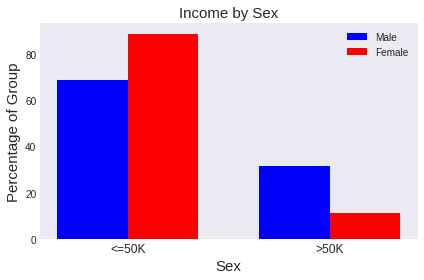

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=1)

bar_width = 0.35

female = clean_adult[clean_adult["sex"] == "Female"]
male = clean_adult[clean_adult["sex"] == "Male"]

male_counts = male["income"].value_counts().sort_index()
male_percents = 100 * male_counts.values/male_counts.values.sum()
ind = np.arange(len(male_percents))
p1 = ax.bar(ind, male_percents, bar_width, color = "blue")

female_counts = female["income"].value_counts().sort_index()
female_percents = 100 * female_counts.values/female_counts.values.sum()
ind = np.arange(len(female_percents))
p2 = ax.bar(ind + bar_width, female_percents, bar_width, color = "red")

ax.set_title("Income by Sex", fontsize = 15)
ax.set_ylabel("Percentage of Group", fontsize = 15)
ax.set_xlabel("Sex", fontsize = 15)
plt.xticks(ind + bar_width/2, female_counts.index, fontsize = 12)

plt.legend((p1[0], p2[0]), ('Male', 'Female'))
plt.tight_layout()
plt.savefig("fig/income_by_sex.png")

Both the Chi-Square Test and the bar chart above show that in 1994, males were far (around 3 times) more likely to earn decent income (>50k/year) than females. The p-value of 1e-309 is shocking but not surprising, and it clearly demonstrates the intrinstic bias against females in the US society of 20 years ago.

In [5]:
%run -i 'functions/two_sample_t_test.py'
clean_adult['income_p'] = 0
for i in range(len(clean_adult)):
    if clean_adult.iloc[i, 14] == ">50K":
        clean_adult.iloc[i, 15] = 1
race = clean_adult.groupby("race")
pairs = [",".join(map(str, comb)).split(",") for comb in combinations(race.groups.keys(), 2)]
for pair in pairs:
    race1_name = pair[0]
    race2_name = pair[1]
    race1 = race.get_group(pair[0])
    race2 = race.get_group(pair[1])
    two_sample_t_test(race1["income_p"], race2["income_p"], race1_name, race2_name)

The mean difference is statistically significant for Group Amer-Indian-Eskimo and Group Asian-Pac-Islander
p-value is 1.45747245226e-10

There is no statistically significant difference between Group Amer-Indian-Eskimo and Group Black

There is no statistically significant difference between Group Amer-Indian-Eskimo and Group Other

The mean difference is statistically significant for Group Amer-Indian-Eskimo and Group White
p-value is 7.88120825344e-13

The mean difference is statistically significant for Group Asian-Pac-Islander and Group Black
p-value is 5.05881494087e-19

The mean difference is statistically significant for Group Asian-Pac-Islander and Group Other
p-value is 5.4775915124e-14

There is no statistically significant difference between Group Asian-Pac-Islander and Group White

There is no statistically significant difference between Group Black and Group Other

The mean difference is statistically significant for Group Black and Group White
p-value is 4.53743917668e-80

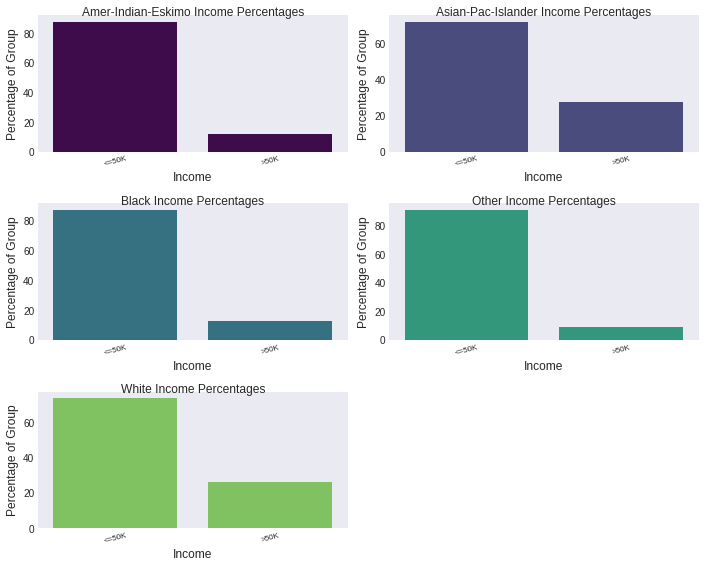

In [6]:
race_groups = clean_adult.groupby("race")
nrows = round((len(race_groups) + 0.0001)/2)
fig, axes = plt.subplots(nrows=nrows, ncols=2, figsize=(10, 8))
row = 0
column = 0
bar_width = 0.35
cmap = cm.get_cmap('viridis')

i = 0
for name, group in race_groups:
    if nrows > 1:
        ax = axes[row, column]
    else:
        ax = axes[column]
    counts = group["income"].value_counts().sort_index()
    percents = 100 * counts.values/counts.values.sum()
    ind = np.arange(len(percents))
    p = sns.barplot(ind, percents, ax =ax, color = cmap(i))
    ax.set_title("Income by Race", fontsize = 15)
    ax.set_ylabel("Percentage of Group", fontsize = 12)
    ax.set_xlabel("Income", fontsize = 12)
    ax.set_xticklabels(counts.index, fontsize = 8, rotation = 15)
    ax.set_title("".join(name) + " Income Percentages", y = 0.95, fontsize=12)

    column = 1 - column
    if column == 0:
        row += 1
    i += 0.2

if column == 1:
    axes[-1, -1].axis("off")
plt.tight_layout()
plt.savefig("fig/income_by_race") 

Both the t-Test and the bar charts above show that in 1994, Asian-Pac-Islanders and Whites were far (around 3 times) more likely to earn decent income (>50k/year) than other ethnic groups. Moreover: 
* There is no statistically significant difference between Asian-Pac-Islanders and Whites, and there is no statistically significant difference among the other three ethnic groups (Black, Amer-Indian-Eskimo and Other). This pattern draws a boundary line between ethnicities with higher and lower income. The p-value for Group White and Group Black was, again, unsurprisingly the smallest. Hence in 1994, **racial bias** was prevalent in income distribution. 
* The p-value for Group White and Group Black (i.e. 4.5e-80) is still much larger than that for males and females (i.e. 1e-309). Hence, it is likely that a Black male earns more than a White female if they have common occupation, education level, etc. The **sexual bias** in income distribution was more serious than the racial bias.

After discussing sex and race, let us look at how occupation affects one's level of income.

In [7]:
chi_square_test(clean_adult,"occupation", "income_p")

statistically significant: ('occupation', 'income_p')
p-value is 0.0


income_p                   0          1
occupation                             
Adm-clerical       14.227068   6.632925
Armed-Forces        0.035314   0.013319
Craft-repair       13.781231  12.093767
Exec-managerial     9.071246  25.799148
Farming-fishing     3.858038   1.531700
Handlers-cleaners   5.592831   1.105487
Machine-op-inspct   7.596892   3.263186
Other-service      13.595833   1.758125
Priv-house-serv     0.626821   0.013319
Prof-specialty      9.830494  24.120938
Protective-serv     1.915776   2.797017
Sales              11.538801  12.919552
Tech-support        2.798623   3.702717
Transport-moving    5.531032   4.248801

(3687.6206511127989, 0.0, 13, array([[  2.79475943e+03,   9.26240568e+02],
        [  6.75969763e+00,   2.24030237e+00],
        [  3.02684238e+03,   1.00315762e+03],
        [  2.99830144e+03,   9.93698561e+02],
        [  7.42815662e+02,   2.46184338e+02],
        [  1.01395464e+03,   3.36045355e+02],
        [  1.47661839e+03,   4.89381606e+02],
        [  2.41246098e+03,   7.99539023e+02],
        [  1.07404085e+02,   3.55959154e+01],
        [  3.03285100e+03,   1.00514900e+03],
        [  4.83693920e+02,   1.60306080e+02],
        [  2.69186181e+03,   8.92138187e+02],
        [  6.84982693e+02,   2.27017307e+02],
        [  1.18069385e+03,   3.91306147e+02]]))

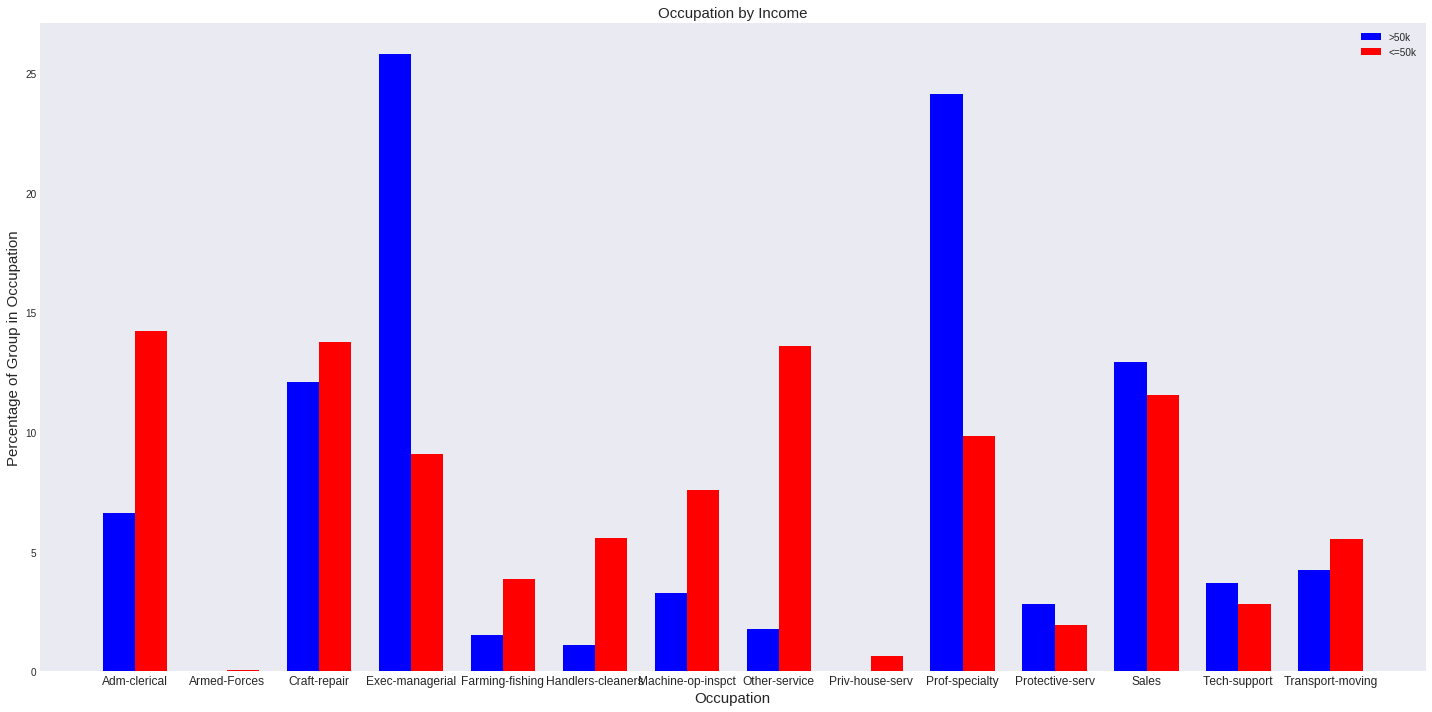

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

below = clean_adult[clean_adult["income_p"] == 0]
above = clean_adult[clean_adult["income_p"] == 1]

above_counts = above["occupation"].value_counts().sort_index()
above_percents = 100 * above_counts.values/above_counts.values.sum()
ind = np.arange(len(above_percents))
p1 = ax.bar(ind, above_percents, bar_width, color = "blue")

below_counts = below["occupation"].value_counts().sort_index()
below_percents = 100 * below_counts.values/below_counts.values.sum()
ind = np.arange(len(below_percents))
p2 = ax.bar(ind + bar_width, below_percents, bar_width, color = "red")

ax.set_title("Occupation by Income", fontsize = 15)
ax.set_ylabel("Percentage of Group in Occupation", fontsize = 15)
ax.set_xlabel("Occupation", fontsize = 15)
plt.xticks(ind + bar_width/2, below_counts.index, fontsize = 12)

plt.legend((p1[0], p2[0]), ('>50k', '<=50k'))
plt.tight_layout()
plt.savefig("fig/occupation by income.png")

The Chi-Square Test and the graph above both denote the huge discrepancy of income level across different occupations. Some of our observations are as follow:
* Occupations that have an obviously decent income include: executive managerial roles and prof-specialty jobs. 
* Occupations that have an obviously indecent income include: other services, handlers and cleaners, farming and fishing, and private house services. 
* The category "other services" shows the most extreme gap (around 8 times) and is closely associated with females and minor ethnicities as discussed from the previous notebooks. Also, every individual in the category "armed-forces" earned less than 50k. It is probable that the country pays the soldiers for protecting our homeland in other intangible methods. 

Last but not the least, let us look at the relationship between income and working hours per week. 

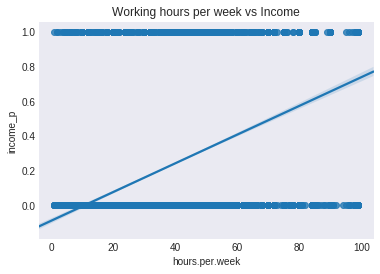

In [9]:
ax = sns.regplot(x = "hours.per.week", y = "income_p", data=clean_adult);
ax.set_title("Working hours per week vs Income");
plt.savefig("fig/hours_income.png")

In [10]:
#Print the summary of the linear regression method.
import statsmodels.formula.api as sm
Y = clean_adult.iloc[:,15]
X = clean_adult.iloc[:,12]
result = sm.OLS(Y, X).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               income_p   R-squared:                       0.286
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                 1.208e+04
Date:                Wed, 06 Dec 2017   Prob (F-statistic):               0.00
Time:                        19:43:54   Log-Likelihood:                -16748.
No. Observations:               30162   AIC:                         3.350e+04
Df Residuals:                   30161   BIC:                         3.351e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
hours.per.week     0.0063   5.69e-05    109.889      0.000       0.006       0.006
==============================================================================
Omnibus:                     5244.723   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6579.542
Skew:                           1.100   Prob(JB):                         0.00
Kurtosis:                       2.369   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As demonstrated by the linear regression, income level tends to get higher if the individual works more. However, the linear method is probably not the best regression method. A **logistic "S" curve** can probably give a better estimation with lower information criteria. The reason is that there is a "threshold" number of working hours, where people who work more than this threshold become much more likely to earn a decent annual income (>50k).